In [0]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

from google.colab import drive
drive.mount('/content/drive')

class MLP(nn.Module):
  def __init__(self, n_units, init_scale=1.0):
    super(MLP, self).__init__()

    self._n_units = copy.copy(n_units)
    self._layers = []
    for i in range(1, len(n_units)):
      layer = nn.Linear(n_units[i-1], n_units[i], bias=False)
      variance = math.sqrt(2.0 / (n_units[i-1] + n_units[i]))
      layer.weight.data.normal_(0.0, init_scale * variance)
      self._layers.append(layer)

      name = 'fc%d' % i
      if i == len(n_units) - 1:
        name = 'fc'  # the prediction layer is just called fc
      self.add_module(name, layer)


  def forward(self, x):
    x = x.view(-1, self._n_units[0])
    out = self._layers[0](x)
    for layer in self._layers[1:]:
      out = F.relu(out)
      out = layer(out)
    return out



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/'My Drive'

/content/drive/My Drive


In [0]:
def get_data():
  normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
  transform_train = transforms.Compose([
          transforms.ToTensor(),
          normalize])
  transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize])
  train_dataset = datasets.CIFAR10(root='data', 
                                train=True, 
                                transform=transform_train,
                                download=True)
  test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transform_test,
                                download=True)  
  train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=2000,
                          num_workers=4,
                          shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=2000,
                         num_workers=4,
                         shuffle=False)
  return train_loader, test_loader

In [0]:
mlp_spec = '512'
n_units = [int(x) for x in mlp_spec.split('x')] # hidden dims
n_units.append(10)  # output dim
n_units.insert(0, 32*32*3)        # input dim
model = MLP(n_units)

In [0]:
from torch.autograd.gradcheck import zero_gradients


def compute_jacobian(inputs, output):
	"""
	:param inputs: Batch X Size (e.g. Depth X Width X Height)
	:param output: Batch X Classes
	:return: jacobian: Batch X Classes X Size
	"""
	assert inputs.requires_grad

	num_classes = output.size()[1]

	jacobian = torch.zeros(num_classes, *inputs.size())
	grad_output = torch.zeros(*output.size())
	if inputs.is_cuda:
		grad_output = grad_output.cuda()
		jacobian = jacobian.cuda()

	for i in range(num_classes):
		zero_gradients(inputs)
		grad_output.zero_()
		grad_output[:, i] = 1
		output.backward(grad_output, retain_graph=True)
		jacobian[i] = inputs.grad.data

	return torch.transpose(jacobian, dim0=0, dim1=1)

In [0]:
#take a single batch of training data and compute jacobian

train_loader, test_loader = get_data()
for batch, data in enumerate(train_loader):
  if batch == 0:
    features, labels = data
    features = torch.autograd.Variable(features, requires_grad=True)
    out = model(features)
    jacobian = compute_jacobian(features, out)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
jacobian.shape

torch.Size([2000, 10, 3, 32, 32])

In [0]:
J = jacobian.reshape(2000, 10*3*32*32)

In [0]:
mat = J @ J.t()
u, v = torch.eig(mat)

In [0]:
w = u[:,0]
w = w[w < 200000]
w = w[w > 1]

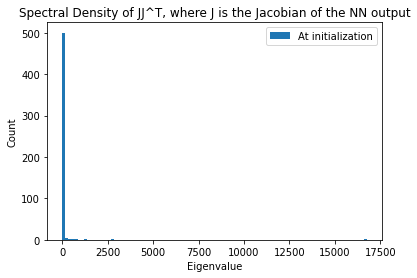

In [0]:
plt.hist(w.detach().numpy(), bins=100, log=False, label= "At initialization")
plt.title("Spectral Density of JJ^T, where J is the Jacobian of the NN output")
plt.xlabel("Eigenvalue")
plt.ylabel("Count")
plt.legend()